In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA, SparsePCA
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eig
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv(r"C:\Users\anjal\Downloads\TNBC_data.csv")

In [3]:
data

,Gene ID,221NC,235NC,241NC,257NC,291NC,293NC,254NC,302NC,221TC,235TC,241TC,254TC,257TC,293TC,291TC,302TC,QCPool1,QCPool2,QCPool3
0,NCLN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DNAJC9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CRK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2696100.0,3043200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GPD1L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8647000.0,NaN,NaN,NaN,NaN,84432000.0,NaN,10741000.0
4,MTA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621,CACYBP,14809000.0,NaN,NaN,1992500.0,NaN,2794200.0,NaN,NaN,NaN,12168000.0,15569000.0,116690000.0,14214000.0,NaN,6970400.0,14675000.0,10743000.0,9872000.0,6774500.0
2622,RRBP1,282620.0,NaN,NaN,81933.0,NaN,549500.0,256490.0,NaN,759750.0,40872000.0,16161000.0,38284000.0,40373000.0,7365200.0,5942800.0,50443000.0,25160000.0,20392000.0,13413000.0
2623,PA2G4,3906500.0,NaN,NaN,NaN,NaN,1133400.0,NaN,NaN,NaN,4843300.0,11930000.0,54184000.0,2362600.0,NaN,NaN,10198000.0,20240000.0,NaN,749070.0
2624,TLN1,11239000.0,1373900.0,11466000.0,4082100.0,465420.0,11231000.0,3120700.0,1050400.0,2372000.0,21619000.0,27187000.0,28419000.0,26019000.0,10401000.0,17168000.0,27104000.0,181330000.0,52296000.0,11927000.0


In [4]:
data.shape

(2626, 20)

I want to know the protein counts in the patients. so that i can get some idea about the missing values.
one can notice that the number protein count is 2180 which is present in atleast 1 patient for the tumor case. 
which means 440 proteins went undetected in all the patients in the Tumor case.

In [5]:
df = pd.DataFrame(data)

value_columns = df.columns.difference(['Gene ID', 'QCPool1', 'QCPool2', 'QCPool3'])

count_dict = {}

for cutoff in range(1, len(value_columns)//2+1):
    non_nan_cnt_TC = df[[col for col in value_columns if "TC" in col]].count(axis=1)
    rows_to_keep = (non_nan_cnt_TC>=cutoff) 
    count_dict[cutoff] = sum(rows_to_keep)

count_table = pd.DataFrame(count_dict.items(), columns=['TC Cutoff', 'Protein Count'])
print(count_table)

   TC Cutoff  Protein Count
0          1           2180
1          2           1940
2          3           1691
3          4           1459
4          5           1212
5          6            965
6          7            734
7          8            501


If I want to know the protein counts in the patients in NC. so that i can get some idea about the missing values.
one can notice that the number protein count is 1559 which is present in atleast 1 patient for the Non tumor case. 
which means 1067 proteins went undetected in all the patients in the Non Tumor case.

In [6]:
count_dict = {}

for cutoff in range(1, len(value_columns)//2+1):
    non_nan_cnt_NC = df[[col for col in value_columns if "NC" in col]].count(axis=1)
    rows_to_keep = (non_nan_cnt_NC>=cutoff)
    count_dict[cutoff] = sum(rows_to_keep)

count_table = pd.DataFrame(count_dict.items(), columns=['NC Cutoff', 'Protein Count'])
print(count_table)

   NC Cutoff  Protein Count
0          1           1559
1          2           1147
2          3            859
3          4            677
4          5            528
5          6            404
6          7            307
7          8            195


here if we notice only 1512 proteins is been diagnosed in atleast 1 patient out of 2626 proteins. but we cannot retain 1512 proteins because it is present in 1 patient and hence based on 1 patient we we cannot impute the values of other patients because it will be essentially duplicating the values hence we set the cutoff 50%.

In [7]:
count_dict = {}

for cutoff in range(1, len(value_columns)//2+1):
    non_nan_cnt_TC = df[[col for col in value_columns if "TC" in col]].count(axis=1)
    non_nan_cnt_NC = df[[col for col in value_columns if "NC" in col]].count(axis=1)
    rows_to_keep = (non_nan_cnt_TC>=cutoff) & (non_nan_cnt_NC>=cutoff)
    count_dict[cutoff] = sum(rows_to_keep)

count_table = pd.DataFrame(count_dict.items(), columns=['TC and NC Cutoff', 'Protein Count'])
print(count_table)

   TC and NC Cutoff  Protein Count
0                 1           1512
1                 2           1083
2                 3            797
3                 4            631
4                 5            477
5                 6            357
6                 7            269
7                 8            168


In [8]:
df_ = df.set_index('Gene ID').T
df_

Gene ID,NCLN,DNAJC9,CRK,GPD1L,MTA1,SH3PXD2A,PLEKHF2,DBT,SCAF4,NDUFB6,...,KHSRP,PLIN4,PARK7,COL12A1,ACO2,CACYBP,RRBP1,PA2G4,TLN1,EMILIN1
221NC,NaN,NaN,NaN,NaN,NaN,26234000.0,NaN,NaN,NaN,NaN,...,10178000.0,152560000.0,53250000.0,NaN,474750.0,14809000.0,282620.0,3906500.0,11239000.0,NaN
235NC,NaN,NaN,NaN,NaN,NaN,7101600.0,NaN,NaN,NaN,NaN,...,NaN,83515000.0,10825000.0,NaN,NaN,NaN,NaN,NaN,1373900.0,NaN
241NC,NaN,NaN,NaN,NaN,NaN,30604000.0,NaN,NaN,NaN,NaN,...,NaN,42868000.0,16012000.0,NaN,NaN,NaN,NaN,NaN,11466000.0,828640.0
257NC,NaN,NaN,NaN,NaN,NaN,4102100.0,NaN,NaN,NaN,NaN,...,1163800.0,94882000.0,16770000.0,NaN,5269000.0,1992500.0,81933.0,NaN,4082100.0,221660.0
291NC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,742190.0,11032000.0,423920.0,NaN,NaN,NaN,NaN,465420.0,NaN
293NC,NaN,NaN,NaN,NaN,NaN,3102800.0,NaN,NaN,NaN,NaN,...,6648000.0,30074000.0,24812000.0,299370.0,4166800.0,2794200.0,549500.0,1133400.0,11231000.0,NaN
254NC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1036900.0,30095000.0,30851000.0,314740.0,422870.0,NaN,256490.0,NaN,3120700.0,1887300.0
302NC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,16882000.0,15184000.0,16217000.0,NaN,NaN,NaN,NaN,1050400.0,4173800.0
221TC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11023000.0,4189600.0,13139000.0,4113700.0,NaN,NaN,759750.0,NaN,2372000.0,3720600.0
235TC,NaN,NaN,2696100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13953000.0,1227900.0,117170000.0,35485000.0,32323000.0,12168000.0,40872000.0,4843300.0,21619000.0,14283000.0


In [13]:
df_.corr().loc['GPD1L'][df_.corr().loc['GPD1L'].notna()]

Gene ID
GPD1L      1.000000
FANCD2     1.000000
GAR1       0.977647
GPNMB      0.999474
YP015      0.635722
             ...   
CACYBP    -0.493428
RRBP1     -0.056184
PA2G4     -0.178213
TLN1       0.993661
EMILIN1    0.988728
Name: GPD1L, Length: 1520, dtype: float64

In [15]:
df_.index

Index(['221NC', '235NC', '241NC', '257NC', '291NC', '293NC', '254NC', '302NC',
       '221TC', '235TC', '241TC', '254TC', '257TC', '293TC', '291TC', '302TC',
       'QCPool1', 'QCPool2', 'QCPool3'],
      dtype='object')

In [16]:
df_['GPD1L'][df_['GPD1L'].notna()]

254TC       8647000.0
QCPool1    84432000.0
QCPool3    10741000.0
Name: GPD1L, dtype: float64

In [9]:
rows_to_keep = (non_nan_cnt_TC>=4) & (non_nan_cnt_NC>=4)
retain_df = df[rows_to_keep]

In [10]:
retain_df = retain_df.set_index('Gene ID').T
retain_df = retain_df.drop(['QCPool1', 'QCPool2', 'QCPool3'])
retain_df

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221NC,10854000.0,15431000.0,2587100.0,31090000.0,141350000.0,5217900.0,NaN,NaN,337700000.0,3841200.0,...,79390000.0,12371000.0,10178000.0,152560000.0,53250000.0,NaN,474750.0,282620.0,11239000.0,NaN
235NC,NaN,16334000.0,1095900.0,17627000.0,11587000.0,NaN,NaN,99329000.0,53950000.0,NaN,...,33000000.0,583440.0,NaN,83515000.0,10825000.0,NaN,NaN,NaN,1373900.0,NaN
241NC,NaN,10241000.0,988680.0,9646800.0,51832000.0,23535000.0,13947000.0,108000000.0,398900000.0,NaN,...,33499000.0,NaN,NaN,42868000.0,16012000.0,NaN,NaN,NaN,11466000.0,828640.0
257NC,NaN,12986000.0,924380.0,8424100.0,14458000.0,6358300.0,NaN,NaN,143530000.0,3489900.0,...,34195000.0,2909500.0,1163800.0,94882000.0,16770000.0,NaN,5269000.0,81933.0,4082100.0,221660.0
291NC,3492100.0,4763900.0,NaN,2931300.0,35289000.0,17571000.0,4898200.0,1760700.0,220840000.0,NaN,...,7058200.0,468820.0,NaN,742190.0,11032000.0,423920.0,NaN,NaN,465420.0,NaN
293NC,8980900.0,NaN,1266400.0,30161000.0,5597600.0,2562200.0,NaN,1777100.0,33940000.0,2526000.0,...,278550000.0,3816300.0,6648000.0,30074000.0,24812000.0,299370.0,4166800.0,549500.0,11231000.0,NaN
254NC,NaN,15211000.0,1223100.0,16635000.0,178520000.0,16453000.0,4763100.0,653980000.0,689260000.0,5977200.0,...,33236000.0,6284900.0,1036900.0,30095000.0,30851000.0,314740.0,422870.0,256490.0,3120700.0,1887300.0
302NC,4883200.0,8181600.0,838750.0,NaN,45673000.0,7536800.0,4354500.0,2019100.0,398530000.0,NaN,...,52515000.0,453110.0,NaN,16882000.0,15184000.0,16217000.0,NaN,NaN,1050400.0,4173800.0
221TC,6025900.0,9608100.0,2124000.0,33082000.0,70533000.0,4152900.0,NaN,1529000.0,843660000.0,NaN,...,47491000.0,8895400.0,11023000.0,4189600.0,13139000.0,4113700.0,NaN,759750.0,2372000.0,3720600.0
235TC,56819000.0,13024000.0,1421800.0,NaN,106960000.0,13834000.0,2213400.0,NaN,226970000.0,NaN,...,289310000.0,32703000.0,13953000.0,1227900.0,117170000.0,35485000.0,32323000.0,40872000.0,21619000.0,14283000.0


# Data Cleaning

In [10]:
NC_data = retain_df.loc['221NC':'302NC']
NC_data

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221NC,10854000.0,15431000.0,2587100.0,31090000.0,141350000.0,5217900.0,NaN,NaN,337700000.0,3841200.0,...,79390000.0,12371000.0,10178000.0,152560000.0,53250000.0,NaN,474750.0,282620.0,11239000.0,NaN
235NC,NaN,16334000.0,1095900.0,17627000.0,11587000.0,NaN,NaN,99329000.0,53950000.0,NaN,...,33000000.0,583440.0,NaN,83515000.0,10825000.0,NaN,NaN,NaN,1373900.0,NaN
241NC,NaN,10241000.0,988680.0,9646800.0,51832000.0,23535000.0,13947000.0,108000000.0,398900000.0,NaN,...,33499000.0,NaN,NaN,42868000.0,16012000.0,NaN,NaN,NaN,11466000.0,828640.0
257NC,NaN,12986000.0,924380.0,8424100.0,14458000.0,6358300.0,NaN,NaN,143530000.0,3489900.0,...,34195000.0,2909500.0,1163800.0,94882000.0,16770000.0,NaN,5269000.0,81933.0,4082100.0,221660.0
291NC,3492100.0,4763900.0,NaN,2931300.0,35289000.0,17571000.0,4898200.0,1760700.0,220840000.0,NaN,...,7058200.0,468820.0,NaN,742190.0,11032000.0,423920.0,NaN,NaN,465420.0,NaN
293NC,8980900.0,NaN,1266400.0,30161000.0,5597600.0,2562200.0,NaN,1777100.0,33940000.0,2526000.0,...,278550000.0,3816300.0,6648000.0,30074000.0,24812000.0,299370.0,4166800.0,549500.0,11231000.0,NaN
254NC,NaN,15211000.0,1223100.0,16635000.0,178520000.0,16453000.0,4763100.0,653980000.0,689260000.0,5977200.0,...,33236000.0,6284900.0,1036900.0,30095000.0,30851000.0,314740.0,422870.0,256490.0,3120700.0,1887300.0
302NC,4883200.0,8181600.0,838750.0,NaN,45673000.0,7536800.0,4354500.0,2019100.0,398530000.0,NaN,...,52515000.0,453110.0,NaN,16882000.0,15184000.0,16217000.0,NaN,NaN,1050400.0,4173800.0


In [11]:
TC_data = retain_df.loc['221TC':'302TC']
TC_data

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221TC,6025900.0,9608100.0,2124000.0,33082000.0,70533000.0,4152900.0,NaN,1529000.0,843660000.0,NaN,...,47491000.0,8895400.0,11023000.0,4189600.0,13139000.0,4113700.0,NaN,759750.0,2372000.0,3720600.0
235TC,56819000.0,13024000.0,1421800.0,NaN,106960000.0,13834000.0,2213400.0,NaN,226970000.0,NaN,...,289310000.0,32703000.0,13953000.0,1227900.0,117170000.0,35485000.0,32323000.0,40872000.0,21619000.0,14283000.0
241TC,23928000.0,27617000.0,1825600.0,63729000.0,64641000.0,5750700.0,9083900.0,980430.0,100860000.0,NaN,...,686430000.0,19246000.0,7578500.0,23887.0,22479000.0,165560000.0,11117000.0,16161000.0,27187000.0,7319700.0
254TC,11266000.0,48783000.0,4494200.0,128920000.0,188490000.0,17349000.0,NaN,NaN,219170000.0,18591000.0,...,947780000.0,23227000.0,72830000.0,1014300.0,86185000.0,102660000.0,19112000.0,38284000.0,28419000.0,16997000.0
257TC,19007000.0,27479000.0,2564500.0,118890000.0,54523000.0,20041000.0,NaN,398000000.0,123010000.0,10714000.0,...,616020000.0,31052000.0,16074000.0,NaN,148720000.0,364720000.0,9828400.0,40373000.0,26019000.0,47643000.0
293TC,NaN,14279000.0,NaN,50044000.0,295120000.0,17390000.0,5424600.0,2276900.0,205540000.0,3037400.0,...,159450000.0,3188300.0,7278200.0,NaN,13760000.0,373050000.0,334040.0,7365200.0,10401000.0,44325000.0
291TC,16086000.0,20028000.0,1476200.0,21192000.0,76157000.0,12473000.0,3844400.0,1908000.0,284240000.0,NaN,...,138680000.0,2467900.0,906160.0,NaN,20333000.0,53380000.0,NaN,5942800.0,17168000.0,8806700.0
302TC,43781000.0,33943000.0,1501100.0,139070000.0,108820000.0,NaN,4953800.0,NaN,332100000.0,2815700.0,...,457230000.0,20974000.0,12025000.0,2047200.0,33298000.0,92121000.0,24435000.0,50443000.0,27104000.0,10986000.0


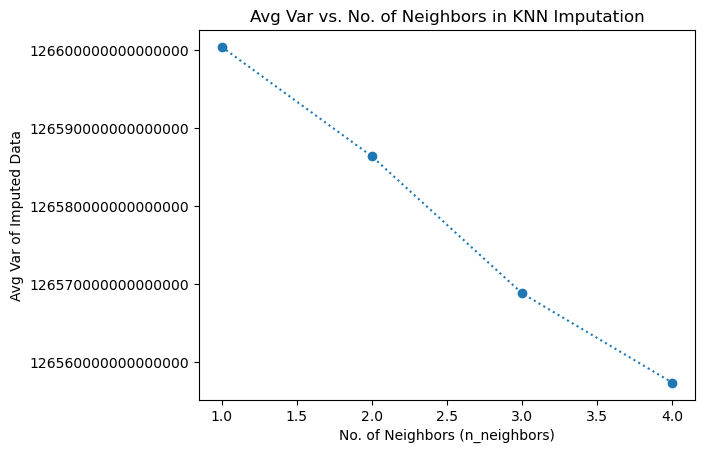

In [12]:
mean_var = []
for i in range(1,5):
    knn_imputer = KNNImputer(n_neighbors=i)
    imputed_nc = knn_imputer.fit_transform(NC_data)
    imputed_nc_data = pd.DataFrame(imputed_nc, columns=NC_data.columns, index=NC_data.index)
    
    mean_variance=np.var(imputed_nc_data).mean()
    mean_var.append(mean_variance)
    
plt.plot(range(1,5), mean_var, marker='o', linestyle='dotted')
plt.xlabel('No. of Neighbors (n_neighbors)')
plt.ylabel('Avg Var of Imputed Data')
plt.title('Avg Var vs. No. of Neighbors in KNN Imputation')
plt.ticklabel_format(style="plain")
plt.show()

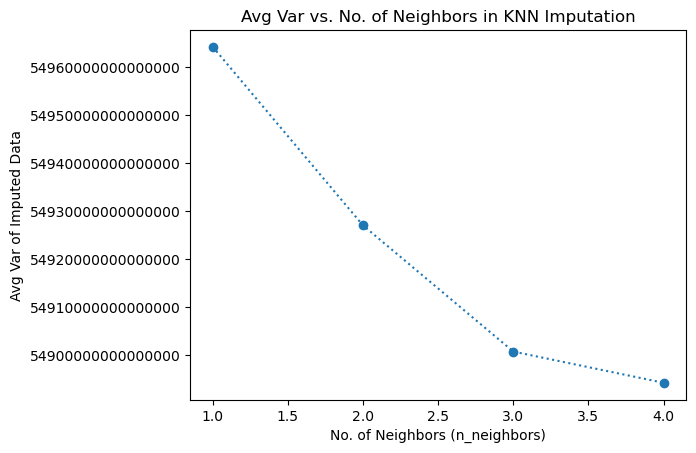

In [13]:
mean_var = []
for i in range(1,5):
    knn_imputer = KNNImputer(n_neighbors=i)
    imputed_tc = knn_imputer.fit_transform(TC_data)
    imputed_tc_data = pd.DataFrame(imputed_tc, columns=TC_data.columns, index=TC_data.index)
    
    mean_variance=np.var(imputed_tc_data).mean()
    mean_var.append(mean_variance)
    
plt.plot(range(1, 5), mean_var, marker='o', linestyle='dotted')
plt.xlabel('No. of Neighbors (n_neighbors)')
plt.ylabel('Avg Var of Imputed Data')
plt.title('Avg Var vs. No. of Neighbors in KNN Imputation')
plt.ticklabel_format(style="plain")
plt.show()

In [14]:
knn_imputer = KNNImputer(n_neighbors=2)
imputed_tc = knn_imputer.fit_transform(TC_data)
imputed_tc_data = pd.DataFrame(imputed_tc, columns=TC_data.columns, index=TC_data.index)
imputed_tc_data

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221TC,6025900.0,9608100.0,2124000.0,33082000.0,70533000.0,4152900.0,3819000.0,1529000.0,843660000.0,2926550.0,...,47491000.0,8895400.0,11023000.0,4189600.0,13139000.0,4113700.0,16328520.0,759750.0,2372000.0,3720600.0
235TC,56819000.0,13024000.0,1421800.0,84467000.0,106960000.0,13834000.0,2213400.0,200138450.0,226970000.0,6875700.0,...,289310000.0,32703000.0,13953000.0,1227900.0,117170000.0,35485000.0,32323000.0,40872000.0,21619000.0,14283000.0
241TC,23928000.0,27617000.0,1825600.0,63729000.0,64641000.0,5750700.0,9083900.0,980430.0,100860000.0,6764850.0,...,686430000.0,19246000.0,7578500.0,23887.0,22479000.0,165560000.0,11117000.0,16161000.0,27187000.0,7319700.0
254TC,11266000.0,48783000.0,4494200.0,128920000.0,188490000.0,17349000.0,3583600.0,199490215.0,219170000.0,18591000.0,...,947780000.0,23227000.0,72830000.0,1014300.0,86185000.0,102660000.0,19112000.0,38284000.0,28419000.0,16997000.0
257TC,19007000.0,27479000.0,2564500.0,118890000.0,54523000.0,20041000.0,3819000.0,398000000.0,123010000.0,10714000.0,...,616020000.0,31052000.0,16074000.0,1121100.0,148720000.0,364720000.0,9828400.0,40373000.0,26019000.0,47643000.0
293TC,37913000.0,14279000.0,1993150.0,50044000.0,295120000.0,17390000.0,5424600.0,2276900.0,205540000.0,3037400.0,...,159450000.0,3188300.0,7278200.0,2708750.0,13760000.0,373050000.0,334040.0,7365200.0,10401000.0,44325000.0
291TC,16086000.0,20028000.0,1476200.0,21192000.0,76157000.0,12473000.0,3844400.0,1908000.0,284240000.0,6764850.0,...,138680000.0,2467900.0,906160.0,1035543.5,20333000.0,53380000.0,17776000.0,5942800.0,17168000.0,8806700.0
302TC,43781000.0,33943000.0,1501100.0,139070000.0,108820000.0,9111850.0,4953800.0,1444215.0,332100000.0,2815700.0,...,457230000.0,20974000.0,12025000.0,2047200.0,33298000.0,92121000.0,24435000.0,50443000.0,27104000.0,10986000.0


In [17]:
knn_imputer = KNNImputer(n_neighbors=2)
imputed_nc = knn_imputer.fit_transform(NC_data)
imputed_nc_data = pd.DataFrame(imputed_nc, columns=NC_data.columns, index=NC_data.index)
imputed_nc_data

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221NC,10854000.0,15431000.0,2587100.0,31090000.0,141350000.0,5217900.0,9355050.0,54888550.0,337700000.0,3841200.0,...,79390000.0,12371000.0,10178000.0,152560000.0,53250000.0,307055.0,474750.0,282620.0,11239000.0,525150.0
235NC,9917450.0,16334000.0,1095900.0,17627000.0,11587000.0,4460250.0,9355050.0,99329000.0,53950000.0,3007950.0,...,33000000.0,583440.0,3905900.0,83515000.0,10825000.0,307055.0,4717900.0,315716.5,1373900.0,525150.0
241NC,9917450.0,10241000.0,988680.0,9646800.0,51832000.0,23535000.0,13947000.0,108000000.0,398900000.0,3665550.0,...,33499000.0,6477220.0,5670900.0,42868000.0,16012000.0,307055.0,2871875.0,182276.5,11466000.0,828640.0
257NC,9917450.0,12986000.0,924380.0,8424100.0,14458000.0,6358300.0,9355050.0,50553050.0,143530000.0,3489900.0,...,34195000.0,2909500.0,1163800.0,94882000.0,16770000.0,307055.0,5269000.0,81933.0,4082100.0,221660.0
291NC,3492100.0,4763900.0,913715.0,2931300.0,35289000.0,17571000.0,4898200.0,1760700.0,220840000.0,4909200.0,...,7058200.0,468820.0,5607450.0,742190.0,11032000.0,423920.0,448810.0,269555.0,465420.0,2501220.0
293NC,8980900.0,14660000.0,1266400.0,30161000.0,5597600.0,2562200.0,9355050.0,1777100.0,33940000.0,2526000.0,...,278550000.0,3816300.0,6648000.0,30074000.0,24812000.0,299370.0,4166800.0,549500.0,11231000.0,525150.0
254NC,9917450.0,15211000.0,1223100.0,16635000.0,178520000.0,16453000.0,4763100.0,653980000.0,689260000.0,5977200.0,...,33236000.0,6284900.0,1036900.0,30095000.0,30851000.0,314740.0,422870.0,256490.0,3120700.0,1887300.0
302NC,4883200.0,8181600.0,838750.0,17010650.0,45673000.0,7536800.0,4354500.0,2019100.0,398530000.0,4909200.0,...,52515000.0,453110.0,5607450.0,16882000.0,15184000.0,16217000.0,448810.0,269555.0,1050400.0,4173800.0


In [18]:
common_data = [imputed_nc_data, imputed_tc_data]
common_data = pd.concat(common_data)
common_data

Gene ID,GPNMB,YP015,PPP1R12A,UTS2,USP29,IGLV3-19,IGHV3-49,TMEM198,CHD9,MYDGF,...,TUBA1A,SERBP1,KHSRP,PLIN4,PARK7,COL12A1,ACO2,RRBP1,TLN1,EMILIN1
221NC,10854000.0,15431000.0,2587100.0,31090000.0,141350000.0,5217900.0,9355050.0,54888550.0,337700000.0,3841200.0,...,79390000.0,12371000.0,10178000.0,152560000.0,53250000.0,307055.0,474750.0,282620.0,11239000.0,525150.0
235NC,9917450.0,16334000.0,1095900.0,17627000.0,11587000.0,4460250.0,9355050.0,99329000.0,53950000.0,3007950.0,...,33000000.0,583440.0,3905900.0,83515000.0,10825000.0,307055.0,4717900.0,315716.5,1373900.0,525150.0
241NC,9917450.0,10241000.0,988680.0,9646800.0,51832000.0,23535000.0,13947000.0,108000000.0,398900000.0,3665550.0,...,33499000.0,6477220.0,5670900.0,42868000.0,16012000.0,307055.0,2871875.0,182276.5,11466000.0,828640.0
257NC,9917450.0,12986000.0,924380.0,8424100.0,14458000.0,6358300.0,9355050.0,50553050.0,143530000.0,3489900.0,...,34195000.0,2909500.0,1163800.0,94882000.0,16770000.0,307055.0,5269000.0,81933.0,4082100.0,221660.0
291NC,3492100.0,4763900.0,913715.0,2931300.0,35289000.0,17571000.0,4898200.0,1760700.0,220840000.0,4909200.0,...,7058200.0,468820.0,5607450.0,742190.0,11032000.0,423920.0,448810.0,269555.0,465420.0,2501220.0
293NC,8980900.0,14660000.0,1266400.0,30161000.0,5597600.0,2562200.0,9355050.0,1777100.0,33940000.0,2526000.0,...,278550000.0,3816300.0,6648000.0,30074000.0,24812000.0,299370.0,4166800.0,549500.0,11231000.0,525150.0
254NC,9917450.0,15211000.0,1223100.0,16635000.0,178520000.0,16453000.0,4763100.0,653980000.0,689260000.0,5977200.0,...,33236000.0,6284900.0,1036900.0,30095000.0,30851000.0,314740.0,422870.0,256490.0,3120700.0,1887300.0
302NC,4883200.0,8181600.0,838750.0,17010650.0,45673000.0,7536800.0,4354500.0,2019100.0,398530000.0,4909200.0,...,52515000.0,453110.0,5607450.0,16882000.0,15184000.0,16217000.0,448810.0,269555.0,1050400.0,4173800.0
221TC,6025900.0,9608100.0,2124000.0,33082000.0,70533000.0,4152900.0,3819000.0,1529000.0,843660000.0,2926550.0,...,47491000.0,8895400.0,11023000.0,4189600.0,13139000.0,4113700.0,16328520.0,759750.0,2372000.0,3720600.0
235TC,56819000.0,13024000.0,1421800.0,84467000.0,106960000.0,13834000.0,2213400.0,200138450.0,226970000.0,6875700.0,...,289310000.0,32703000.0,13953000.0,1227900.0,117170000.0,35485000.0,32323000.0,40872000.0,21619000.0,14283000.0


In [20]:
import scipy.stats as stats
# Perform Shapiro-Wilk test
statistic, p_value = stats.shapiro(common_data)

# Set the significance level (alpha)
alpha = 0.05

# Check if the null hypothesis (data is normally distributed) can be rejected
if p_value < alpha:
    print("The data does not follow a normal distribution (reject H0)")
else:
    print("The data follows a normal distribution (fail to reject H0)")


The data does not follow a normal distribution (reject H0)


In [21]:
# # Split data into tumor and non-tumor groups
# tumor_group = data[data['Group'] == 'Tumor']
# nontumor_group = data[data['Group'] == 'Non-Tumor']

# Initialize a DataFrame to store t-test results
t_test_results = pd.DataFrame(columns=['Protein', 'T-Statistic', 'P-Value'])

# Perform t-test for each protein
for protein in common_data.columns[1:]:  # Assuming the first column contains group labels
    t_stat, p_value = stats.ttest_ind(imputed_tc_data[protein], imputed_nc_data[protein], equal_var=False)
    t_test_results = t_test_results.append({'Protein': protein, 'T-Statistic': t_stat, 'P-Value': p_value}, ignore_index=True)

# Correct for multiple testing (FDR correction)
from statsmodels.stats.multitest import multipletests

t_test_results['FDR'] = multipletests(t_test_results['P-Value'], method='fdr_bh')[1]

# Filter significant proteins (e.g., FDR < 0.05)
significant_proteins = t_test_results[t_test_results['FDR'] < 0.07]

# Print or save significant proteins
print(significant_proteins.sort_values(by = 'FDR', ascending=False))

    Protein  T-Statistic   P-Value       FDR
516   ANXA2     3.097982  0.011265  0.067451
45     GLRX     3.068344  0.011456  0.067451
260   RPS13     3.384384  0.011438  0.067451
2      UTS2     3.872211  0.005107  0.066963
423   YWHAE     3.239496  0.010932  0.066963
..      ...          ...       ...       ...
613   POSTN     4.951092  0.001601  0.064961
19   SLC2A1     4.679342  0.000773  0.064961
301    NT5E    -5.444686  0.000090  0.023358
123  COX7A2     6.555700  0.000083  0.023358
216     CFI    -5.350584  0.000111  0.023358

[107 rows x 4 columns]


In [22]:
common_data.to_csv('tumor_impute.csv', index=False)

In [23]:
variance = np.var(common_data).mean()
variance

1.092960171952995e+17

The assumption behind using KNN for missing values is that a point value can be approximated by the values of the points that are closest to it, based on other variables.

In [19]:
scaler = StandardScaler()
common_data_scl = pd.DataFrame(scaler.fit_transform(common_data), columns=common_data.columns, index=common_data.index)
# sigma = common_data.cov()
# lambda_, eig_vec = eig(np.array(sigma))
# frame = pd.DataFrame({'values': lambda_, 'vector':[str(i) for i in np.transpose(eig_vec)]})

# pca = pd.DataFrame()
# for i in range(len(lambda_)):
#     pca['PCA'+str(i+1)] = np.dot(np.transpose(eig_vec)[i], np.transpose(common_data_scl))
    
# variances = [np.var(pca[i]) for i in pca.columns]
# var_prop = variances/np.sum(variances)
# var_prop

In [20]:
pca = PCA(0.95)
pc = pca.fit_transform(common_data_scl)

In [21]:
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

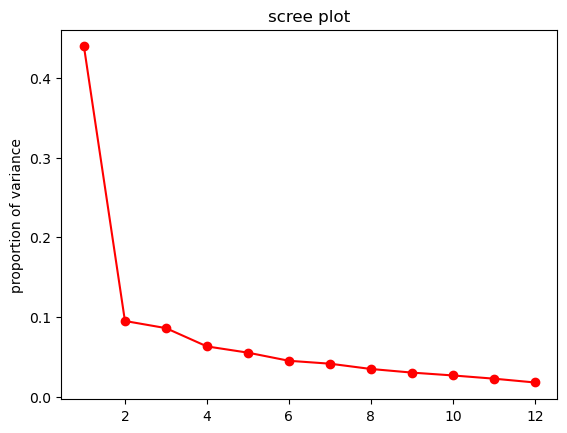

In [22]:
PC_number = np.arange(pca.n_components_)+1

plt.plot(PC_number, prop_var, 'ro-')
plt.title('scree plot')
plt.ylabel('proportion of variance')
plt.show()

In [23]:
pca.n_components_

12

In [24]:
component_label = [f'PCA{i+1}' for i in range(12)]
pca_df = pd.DataFrame(data=pc, columns=component_label)
pca_df

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12
0,-7.571253,-8.728497,2.259719,5.117536,-8.908519,5.450929,4.446537,4.872720,9.357945,-4.190527,-1.840098,-2.345043
1,-13.203857,-0.814111,4.416123,8.646018,-0.514306,-7.190761,-0.854773,-0.162326,-6.043670,6.519580,-0.902023,-5.663329
2,-15.434763,9.529034,12.186622,-0.781356,-0.608290,-9.346156,6.484943,1.029580,4.811261,0.899451,5.365185,3.005162
3,-12.292719,-8.349928,-2.174096,8.816136,-1.732279,-0.745673,-2.504817,0.733995,-3.601257,-0.352278,-2.926777,2.730111
4,-13.835532,0.151427,2.037921,-8.693379,-0.603233,-1.957646,0.342830,-5.270692,-3.722351,-8.542296,1.465197,-1.568652
5,-8.818087,-7.549231,-4.847981,7.466837,-1.570592,-0.635058,-5.541145,-3.961558,-0.016753,-1.070726,3.191979,6.779187
6,-10.679860,3.721105,5.563967,-6.438748,-2.757770,11.090504,3.940652,-1.926932,-1.526583,8.651372,-3.570051,3.619391
7,-13.432346,-2.120574,0.565748,-5.360018,-1.470638,0.854595,-0.438866,-0.534193,-2.118158,-2.160454,-3.691930,-5.727958
8,-5.318249,-5.880529,-4.841805,-1.225232,9.604365,7.545145,-1.083880,2.407781,1.097069,2.870793,9.923776,-3.694292
9,14.715921,-1.519282,-10.631128,3.480669,9.298708,-2.070792,13.027888,-6.306882,0.941583,-0.576599,-3.256991,0.339819


In [25]:
eigenvalues

array([295.66572105,  64.01961095,  57.99806   ,  42.55800216,
        37.29401948,  30.44096449,  27.98464156,  23.51782403,
        20.46728949,  18.0606769 ,  15.34744027,  12.12673919])

In [26]:
prop_var.sum()

0.9590149409232289

In [27]:
loadings=pca.components_
feature_imp = np.abs(loadings)
# total_feat_imp = feature_imp.sum(axis=0)

# feature_names = common_data_scl.columns
# feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': total_feat_imp})

# feature_imp_df = feature_imp_df.sort_values(by="Importance",ascending=False)
# print(feature_imp_df)

feature_importance = np.abs(loadings).sum(axis=0)
feature_names = common_data_scl.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

      Feature  Importance
107  SH3BGRL3    0.609211
121     DEFA3    0.592912
311  SLC25A11    0.584642
409     PRELP    0.582171
7     TMEM198    0.581203
..        ...         ...
532   HNRNPA1    0.154713
450      GDI2    0.149691
592    HNRNPK    0.149201
508     RPLP2    0.140955
438      RPL4    0.128166

[631 rows x 2 columns]


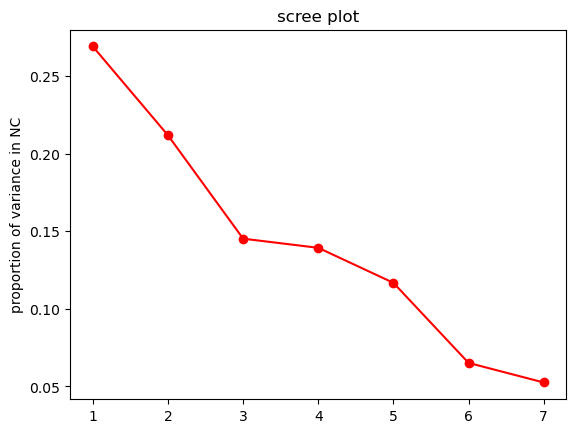

     Feature  Importance
394    RAB7A    0.309778
92   ALDH1A1    0.306868
193   S100A8    0.305699
352      AFM    0.304662
626  COL12A1    0.299474
..       ...         ...
625    PARK7    0.145570
588      VCP    0.143910
18     RPL34    0.141901
240    CRYAB    0.133964
254   MT-CO2    0.119156

[631 rows x 2 columns]


In [28]:
scaler = StandardScaler()
imputed_nc_data_scl = pd.DataFrame(scaler.fit_transform(imputed_nc_data), columns=imputed_nc_data.columns, index=imputed_nc_data.index)
pca_nc = PCA(0.98)
pc_nc = pca_nc.fit_transform(imputed_nc_data_scl)
prop_var_nc = pca_nc.explained_variance_ratio_
eigenvalues_nc = pca_nc.explained_variance_

PC_nc_number = np.arange(pca_nc.n_components_)+1

plt.plot(PC_nc_number, prop_var_nc, 'ro-')
plt.title('scree plot')
plt.ylabel('proportion of variance in NC')
plt.show()

loadings=pca_nc.components_
feature_imp = np.abs(loadings)
total_feat_imp = feature_imp.sum(axis=0)

feature_names = imputed_nc_data_scl.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': total_feat_imp})

feature_imp_df = feature_imp_df.sort_values(by="Importance",ascending=False)
print(feature_imp_df)

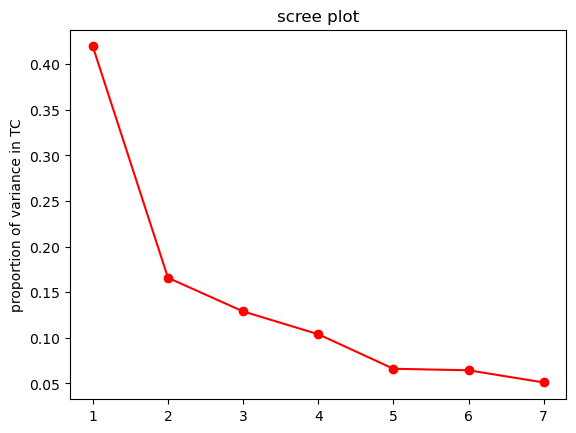

     Feature  Importance
522    THBS1    0.332140
309    CDC5L    0.331195
239   HNRNPR    0.328655
499      VTN    0.328451
250   SEC22B    0.328104
..       ...         ...
238    RPS19    0.114149
508    RPLP2    0.109802
532  HNRNPA1    0.109079
215    RPS18    0.108882
438     RPL4    0.107852

[631 rows x 2 columns]


In [29]:
scaler = StandardScaler()
imputed_tc_data_scl = pd.DataFrame(scaler.fit_transform(imputed_tc_data), columns=imputed_tc_data.columns, index=imputed_tc_data.index)
pca_tc = PCA(0.98)
pc_tc = pca_tc.fit_transform(imputed_tc_data_scl)
prop_var_tc = pca_tc.explained_variance_ratio_
eigenvalues_tc = pca_tc.explained_variance_

PC_tc_number = np.arange(pca_tc.n_components_)+1

plt.plot(PC_tc_number, prop_var_tc, 'ro-')
plt.title('scree plot')
plt.ylabel('proportion of variance in TC')
plt.show()

loadings=pca_tc.components_
feature_imp = np.abs(loadings)
total_feat_imp = feature_imp.sum(axis=0)

feature_names = imputed_tc_data_scl.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': total_feat_imp})

feature_imp_df = feature_imp_df.sort_values(by="Importance",ascending=False)
print(feature_imp_df)

A disadvantage of principal components is that every predictor receives a nonzero weight for every component, so many coefficients are involved even through the effective degrees of freedom with respect to the response model are reduced. Sparse principal components (Witten & Tibshirani, 2008) uses a penalty function to reduce the magnitude of the loadings variables receive in the components. If an L1 penalty is used (as with the lasso, some loadings are shrunk to zero, resulting in some simplicity. Sparse principal components combines some elements of variable clustering, scoring of variables within clusters, and redundancy analysis

In [30]:
# Create a Sparse PCA model
n_components = 3  # Set the number of components
alpha = 0.1  # Set the sparsity controlling parameter
sparse_pca = SparsePCA(n_components=n_components, alpha=alpha)

# Fit the model to your data
X = ...  # Your data matrix
sparse_pca.fit(common_data_scl)

# Get the components and their loadings
# components = sparse_pca.components_  # These are the principal components
loadings = sparse_pca.components_

# Identify important features based on loadings
important_features = []
for component in loadings:
    important_feature_indices = np.where(component != 0)[0]
    important_features.append(important_feature_indices)

# Print the important features for each component
for i, features in enumerate(important_features):
    print(f"Important features for Component {i+1}: {features}")

Important features for Component 1: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  20  21
  23  24  26  27  28  29  30  31  32  34  35  36  37  38  39  40  41  42
  43  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  83  84  85  86  87  89  90  91  92  93  95  96  97  98  99 100 101
 102 103 105 106 107 108 110 111 112 113 114 115 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 137 138 140 141 142
 143 144 145 146 147 149 150 151 152 153 154 155 156 158 159 160 161 162
 163 164 165 167 168 169 170 171 172 173 174 175 176 177 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 203 204 205 207 208 209 210 211 212 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 238 239 240
 241 242 243 244 246 247 248 249 250 251 252 253 254 255 256 257 258 260
 261 262 263 26

In [31]:
percent_var = []
for n_comp in range(1, 10):
    sparse_pca = SparsePCA(n_components=n_comp+1)
    sparse_pca.fit(common_data_scl)
    x_sparse_pca = sparse_pca.transform(common_data_scl)
    total_var = 100*np.mean(sparse_pca.components_ == 0)
    percent_var.append(total_var)
var_explained = [percent_var[0]]+[(percent_var[i+1] - percent_var[i]) for i in range(len(percent_var)-1)]
var_explained

[48.49445324881141,
 6.180665610142633,
 6.616481774960377,
 3.4944532488114177,
 2.673005810882188,
 2.611123688778207,
 1.9385329409101217,
 2.2297059341433254,
 1.9105476316252918]

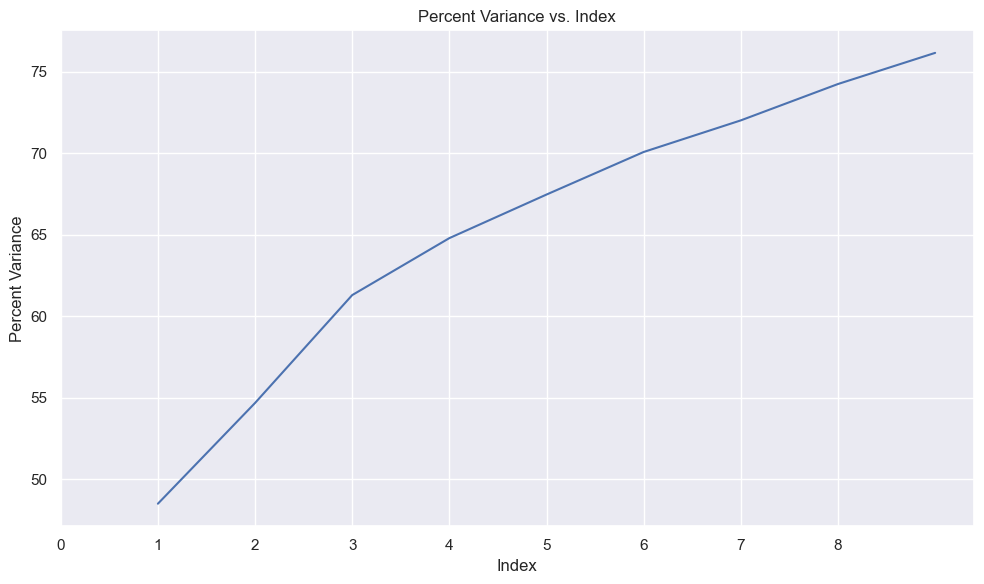

In [32]:
sns.set(rc={'figure.figsize': (6, 6)})
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(percent_var)+1), percent_var)
plt.xlabel("Index")
plt.ylabel("Percent Variance")
plt.xticks(range(len(percent_var)), range(len(percent_var)))  # Set x-ticks as indices
plt.title("Percent Variance vs. Index")
plt.tight_layout()
plt.show()

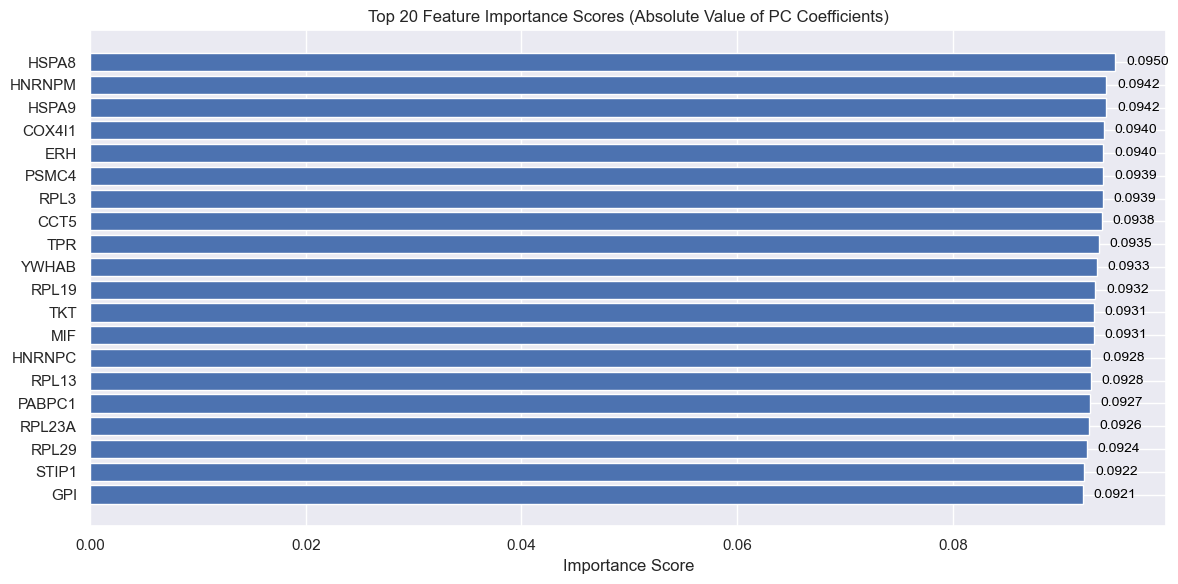

In [33]:
pc = sparse_pca.components_[0]
feature_names = common_data_scl.columns
sorted_indices = np.argsort(np.abs(pc))[::-1]
sorted_importances = pc[sorted_indices]

sorted_feature_names = [feature_names[i] for i in sorted_indices]

sorted_indices = np.argsort(np.abs(pc))[::-1]
sorted_importances = np.abs(pc[sorted_indices])
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Select the top N features (e.g., top 20) in decreasing order of importance
n_top_features = 20
top_indices = sorted_indices[:n_top_features][::-1]
top_importances = sorted_importances[:n_top_features][::-1]
top_feature_names = sorted_feature_names[:n_top_features][::-1]

# Create a horizontal bar plot with annotations to visualize the top N feature importances
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_importances)), top_importances)
plt.xlabel("Importance Score")
plt.yticks(range(len(top_importances)), top_feature_names)
plt.title(f"Top {n_top_features} Feature Importance Scores (Absolute Value of PC Coefficients)")

for i, v in enumerate(top_importances):
    plt.text(v + 0.001, i, f"{v:.4f}", va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [34]:
loadings = sparse_pca.components_
feature_importance = np.abs(loadings).sum(axis=0)
feature_names = common_data_scl.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

     Feature  Importance
460      CAT    0.280964
519      DCN    0.276467
523   COL1A2    0.273891
13   ALDH1L1    0.263093
486   COL1A1    0.262473
..       ...         ...
497      LTF    0.033290
456    FSCN1    0.032897
121    DEFA3    0.030348
250   SEC22B    0.014964
309    CDC5L    0.005748

[631 rows x 2 columns]


<Figure size 2000x2000 with 0 Axes>

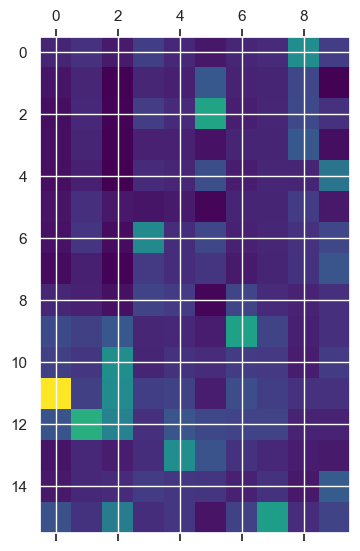

<Figure size 2000x2000 with 0 Axes>

In [35]:

plt.matshow(x_sparse_pca,cmap='viridis')
plt.figure(figsize=(20,20))

In [36]:
sparse_pca.get_feature_names_out(common_data_scl.columns)

array(['sparsepca0', 'sparsepca1', 'sparsepca2', 'sparsepca3',
       'sparsepca4', 'sparsepca5', 'sparsepca6', 'sparsepca7',
       'sparsepca8', 'sparsepca9'], dtype=object)

In [37]:
sparse_pca.get_params()

{'U_init': None,
 'V_init': None,
 'alpha': 1,
 'max_iter': 1000,
 'method': 'lars',
 'n_components': 10,
 'n_jobs': None,
 'random_state': None,
 'ridge_alpha': 0.01,
 'tol': 1e-08,
 'verbose': False}

[dict_learning] ....................


NameError: name 'loads' is not defined

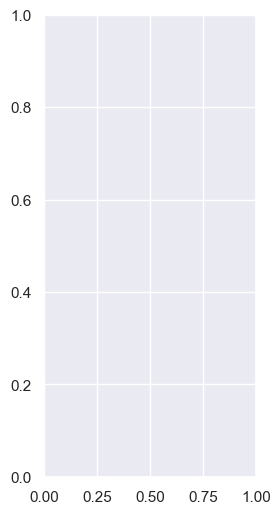

In [38]:
n_components=2
sparse_pca = SparsePCA(n_components=n_components, verbose=True)
sparse_pca.fit(common_data_scl)
x_sparse_pca = sparse_pca.transform(common_data_scl)

for i in range(n_components):
    plt.subplot(1, n_components, i+1)
    plt.bar(range(len(loads[i])), loads[i])
    plt.title(f'Comp{i+1}')
    plt.xlabel('Proteins')      
    plt.ylabel('Loading value')
plt.tight_layout()
plt.show()

In [24]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

# Assuming 'data' is your data in the form of a dense NumPy array or sparse matrix
# If it's not already sparse, apply L1 normalization to make it sparse
sparse_data = normalize(common_data, norm='l1', axis=1)

# Set the number of clusters (K) you want to create
K = 5

# Initialize the K-means clustering algorithm
kmeans = KMeans(n_clusters=K, random_state=0)

# Fit the K-means model to your sparse data
kmeans.fit(sparse_data)

# Get cluster assignments for each data point
cluster_labels = kmeans.labels_

# Get cluster centroids (or means)
cluster_centers = kmeans.cluster_centers_

# The 'cluster_labels' variable contains the cluster assignments for each data point
# The 'cluster_centers' variable contains the cluster centroids

# You can use these cluster assignments to analyze your data or visualize the results


In [27]:
cluster_centers.view()

array([[6.23633590e-04, 3.68042322e-04, 3.93459169e-05, ...,
        4.87046643e-04, 3.32995908e-04, 5.38715146e-04],
       [2.23836366e-04, 2.80352139e-04, 3.11916317e-05, ...,
        4.10116499e-05, 2.41141516e-04, 6.42947282e-05],
       [1.45142560e-04, 2.27235560e-04, 3.53453116e-05, ...,
        1.13833382e-05, 5.16833621e-05, 6.01383491e-05],
       [7.46922010e-05, 1.15945417e-04, 1.54856623e-05, ...,
        4.77286199e-06, 1.36485667e-05, 5.97492719e-05],
       [4.35915141e-04, 5.37744178e-04, 3.66905035e-05, ...,
        2.04515472e-04, 3.08664782e-04, 6.49422001e-05]])